# Part 2: RNN

### Upload the dataset for creation of RNN, and check characteristics

In [3]:
# to donwload the file you need to have you kaggle api token istalled the path should be ~/.kaggle/kaggle.json
# The kaggle.json file should look like this:
# {
#   "username": "your_username",
#   "key": "your_key"
# }
from kaggle.api.kaggle_api_extended import KaggleApi
import os

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Specify the competition name (bike-sharing-demand)
competition_name = 'bike-sharing-demand'

# Specify the download path
download_path = './bike-sharing'

# Download the competition dataset
api.competition_download_files(competition_name, path=download_path)

print(f"Dataset downloaded to {download_path}")


Dataset downloaded to ./bike-sharing


In [4]:
import zipfile

# Unzip the dataset
with zipfile.ZipFile(f'{download_path}/{competition_name}.zip', 'r') as zip_ref:
    zip_ref.extractall(download_path)

print("Dataset extracted.")

Dataset extracted.


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import seaborn as sns

In [9]:
train_dir = "./bike-sharing/train"
test_dir = "./bike-sharing/test"

# Crea els directoris si no existeixen
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Mou els fitxers
os.rename("./bike-sharing/train.csv", f"{train_dir}/train.csv")
os.rename("./bike-sharing/test.csv", f"{test_dir}/test.csv")

In [31]:
# Charge the training dataset   
df = pd.read_csv("./bike-sharing/train/train.csv")
print(df.head())
# Prove there are no missing values
print("Missing values in training dataset:", df.isnull().sum().sum())

for col in df.columns:
    print(f"nº unique values '{col}':", df[col].nunique())
    print(f"Name attributes '{col}':", df[col].unique())
    
# Categorical attributes
categorical_attributes = ['season', 'holiday', 'workingday', 'weather', 'datetime']
# Numerical attributes
numerical_attributes = ['temp', 'atemp', 'humidity', 'windspeed', 'count']


              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  
Missing values in training dataset: 0
nº unique values 'datetime': 10886
Name attributes 'datetime': ['2011-01-01 00:00:00' '2011-01-01 01:00:00' '2011-01-01 02:00:00' ...
 '2012-12-19 21:00:00' '2012-12-19 22:00:00' '2

Now we have understood the basic characterstics of the dataset, and we know the following metadata:

**Data Fields**

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

### Exploratory Data Analysis

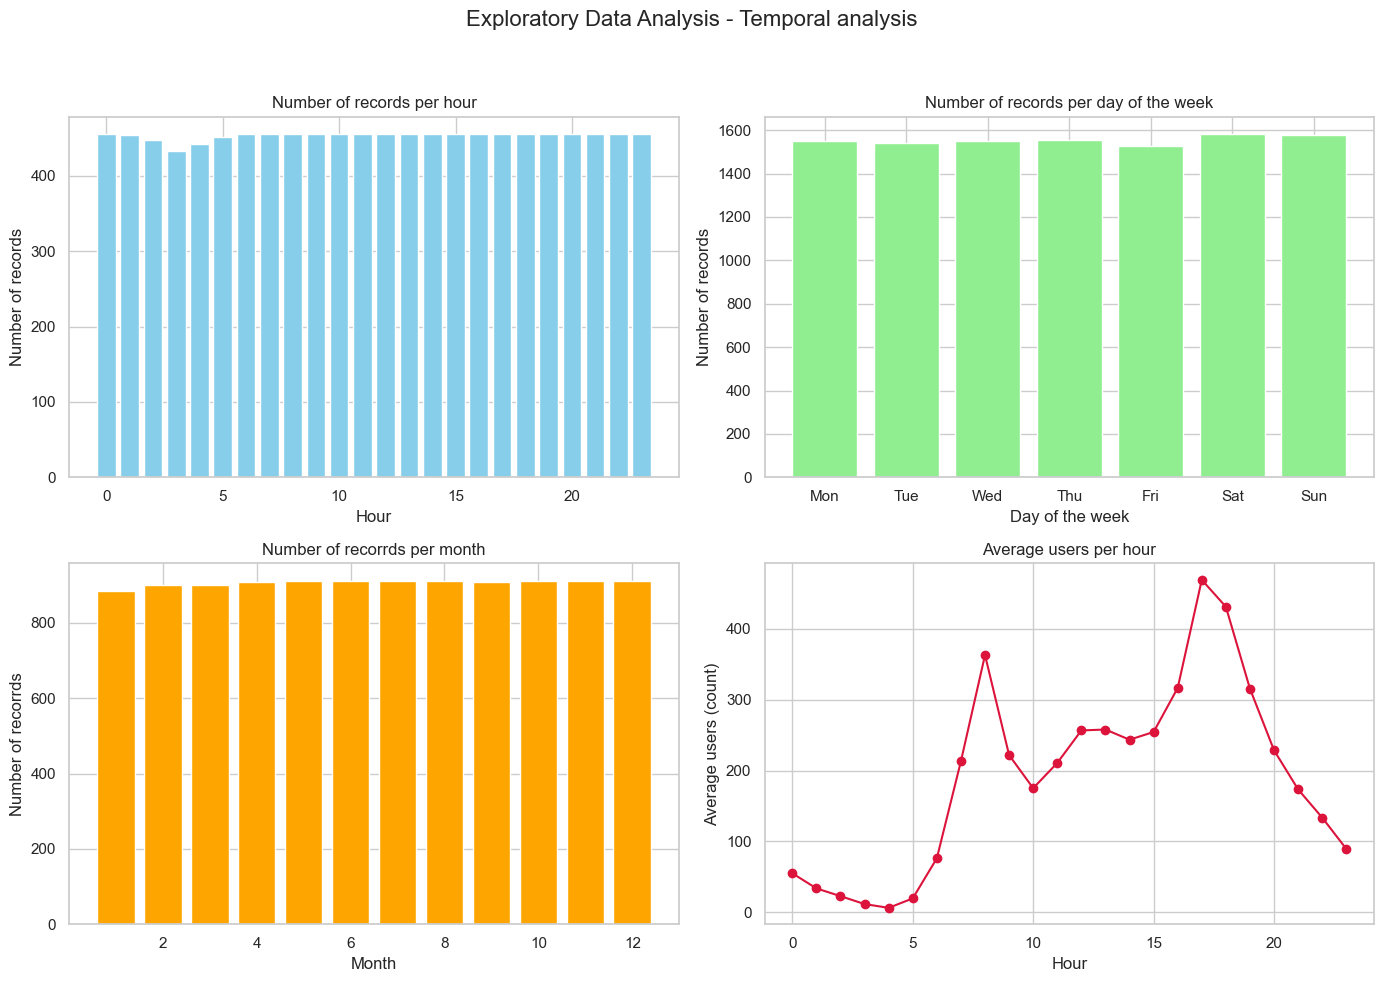

In [29]:
# Converteix la columna 'datetime' a format datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Extreu característiques temporals
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek  # 0 = Monday
df['month'] = df['datetime'].dt.month

# Defineix noms dels dies
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Prepara la figura
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Exploratory Data Analysis - Temporal analysis", fontsize=16)

# Number of records per hour
hour_counts = df['hour'].value_counts().sort_index()
axs[0, 0].bar(hour_counts.index, hour_counts.values, color='skyblue')
axs[0, 0].set_title("Number of records per hour")
axs[0, 0].set_xlabel("Hour")
axs[0, 0].set_ylabel("Number of records")

# Number of records per day of the week
day_counts = df['dayofweek'].value_counts().sort_index()
axs[0, 1].bar(day_counts.index, day_counts.values, color='lightgreen')
axs[0, 1].set_title("Number of records per day of the week")
axs[0, 1].set_xlabel("Day of the week")
axs[0, 1].set_ylabel("Number of records")
axs[0, 1].set_xticks(range(7))
axs[0, 1].set_xticklabels(day_names)

# Number of records per month
month_counts = df['month'].value_counts().sort_index()
axs[1, 0].bar(month_counts.index, month_counts.values, color='orange')
axs[1, 0].set_title("Number of recorrds per month")
axs[1, 0].set_xlabel("Month")
axs[1, 0].set_ylabel("Number of recorrds")

# Average users per hour
hourly_mean = df.groupby('hour')['count'].mean()
axs[1, 1].plot(hourly_mean.index, hourly_mean.values, marker='o', color='crimson')
axs[1, 1].set_title("Average users per hour")
axs[1, 1].set_xlabel("Hour")
axs[1, 1].set_ylabel("Average users (count)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

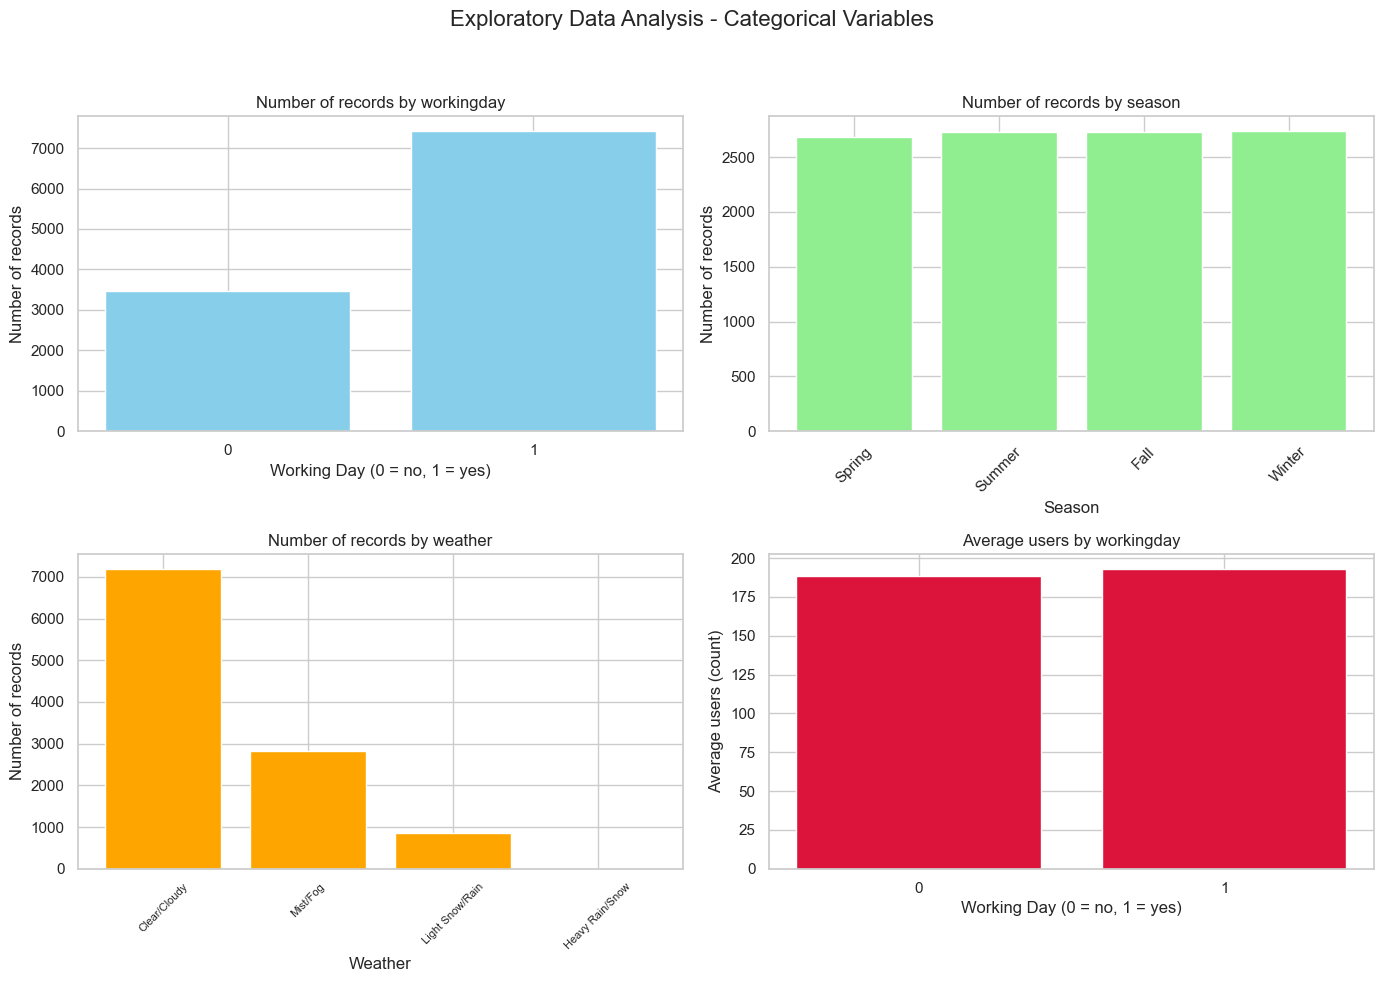

In [37]:
# Defineix noms per a seasons i weather (segons la documentació del dataset)
season_names = ['Spring', 'Summer', 'Fall', 'Winter']
weather_names = [
    'Clear/Cloudy',
    'Mist/Fog',
    'Light Snow/Rain',
    'Heavy Rain/Snow'
]

# Prepara la figura
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Exploratory Data Analysis - Categorical Variables", fontsize=16)

# Workingday counts (0 or 1)
workingday_counts = df['workingday'].value_counts().sort_index()
axs[0, 0].bar(workingday_counts.index, workingday_counts.values, color='skyblue')
axs[0, 0].set_title("Number of records by workingday")
axs[0, 0].set_xlabel("Working Day (0 = no, 1 = yes)")
axs[0, 0].set_ylabel("Number of records")
axs[0, 0].set_xticks([0, 1])

# Season counts (1 to 4)
season_counts = df['season'].value_counts().sort_index()
axs[0, 1].bar(season_counts.index, season_counts.values, color='lightgreen')
axs[0, 1].set_title("Number of records by season")
axs[0, 1].set_xlabel("Season")
axs[0, 1].set_ylabel("Number of records")
axs[0, 1].set_xticks(range(1, 5))
axs[0, 1].set_xticklabels(season_names, rotation=45)

# Weather counts (1 to 4)
weather_counts = df['weather'].value_counts().sort_index()
axs[1, 0].bar(weather_counts.index, weather_counts.values, color='orange')
axs[1, 0].set_title("Number of records by weather")
axs[1, 0].set_xlabel("Weather")
axs[1, 0].set_ylabel("Number of records")
axs[1, 0].set_xticks(range(1, 5))
axs[1, 0].set_xticklabels(weather_names, rotation=45, fontsize=8)

# Average users per workingday (0 or 1)
avg_users_workingday = df.groupby('workingday')['count'].mean()
axs[1, 1].bar(avg_users_workingday.index, avg_users_workingday.values, color='crimson')
axs[1, 1].set_title("Average users by workingday")
axs[1, 1].set_xlabel("Working Day (0 = no, 1 = yes)")
axs[1, 1].set_ylabel("Average users (count)")
axs[1, 1].set_xticks([0, 1])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
